In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

from contextily import add_basemap
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Polygon

sns.set_style('whitegrid')

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## 1. Read the data which contains the vehicles for the time-space diagram 

In [2]:
comp_df = pd.read_csv("../data/sample_data.csv")

## 2. Filter vehicles with a street segment (skip this step for unfiltered plots)

In [3]:
from shapely.strtree import STRtree
import geojson, json 
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, shape, Polygon

num_vehicles = list(comp_df.id.unique())


# specify the geometry of the source and sink zone at the two ends of the arterial to capture
# the vehicles passing over through the section. Example geomteries are shown below:
# Origin cross-section zone. This could be over single or multiple lanes
street_shape_1 = [Polygon(((23.73267889022827,37.97841373853048), (23.73281836509705,37.97819385812107),
                            (23.73327970504761,37.97842219545615), (23.73314023017883,37.97865898897925), 
                            (23.73267889022827,37.97841373853048)))]

# Destination cross-section zone. This could be over single or multiple lanes
street_shape_2 = [Polygon(((23.72933149337769,37.98230382146053), (23.72949242591858,37.98208395270612), 
                           (23.73008251190185,37.98230382146053), (23.72987866401672,37.98256597180672), 
                            (23.72933149337769,37.98230382146053)))]
s1 = STRtree(street_shape_1)
s2 = STRtree(street_shape_2)

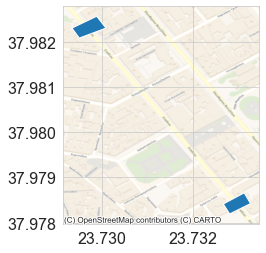

In [4]:
# Create a DataFrame with polygon data
data = {'ID': [1, 2],
        'geometry': [street_shape_1[0],
                     street_shape_2[0]]}

df = pd.DataFrame(data)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# Display the GeoDataFrame
ax = gdf.plot()
add_basemap(ax, crs = "EPSG:4326", source=ctx.providers.CartoDB.Voyager)
plt.show()

In [ ]:
list_vehicles = []
list_frame_start = []
list_frame_end = []

for i in tqdm(np.sort(num_vehicles)):
    temp = comp_df[comp_df.id==i]    
    geometry = [Point(xy) for xy in zip(temp.lon, temp.lat)]
    frame = list(temp.frame)
    counter=0
    for _, p1 in enumerate(zip(geometry, frame)):
        if counter==0:
            result1 = s1.query(p1[0])
            if street_shape_1[0] in result1:
                list_frame_end.append(p1[1])
                for _, p2 in enumerate(zip(geometry, frame)):
                    if counter==0:
                        result2 = s2.query(p2[0])
                        if street_shape_2[0] in result2:
                            list_vehicles.append(i)
                            list_frame_start.append(p2[1])
                            counter=1


In [ ]:
# running this cell with the sample data will give error, 
# because (presumably) these vehicles are not in the scope of above shapes

comp_df = comp_df[comp_df.id.isin(list_vehicles)]

temp_df = []

for k, vehicle in enumerate(np.sort(comp_df.id.unique())):
    temp = comp_df[comp_df.id==vehicle]
    temp = temp[temp.frame>list_frame_start[k]]
    temp = temp[temp.frame<list_frame_end[k]]
    temp_df.append(temp)

comp_df = pd.concat(temp_df)

## 3. Color the points based on the speed magnitude and plot the TS diagram

In [5]:
v_max = np.percentile(comp_df.v, 95)
v_min = np.percentile(comp_df.v, 5)

list_color = []

for i in tqdm(comp_df.id.unique()):
    
    temp = comp_df[comp_df.id==i]
    color = [((v_max-i)/(v_max-v_min), 0, (i-v_min)/(v_max-v_min)) for i in list(temp.v)]
    
    color_df = pd.DataFrame(color)
    list_color.append(color_df)
    
color_df = pd.concat(list_color)
scaler = MinMaxScaler()
color_df = pd.DataFrame(scaler.fit_transform(color_df))
colors = color_df.values

100%|██████████| 6/6 [00:00<00:00, 102.57it/s]
/Users/vishal/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/vishal/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/vishal/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/vishal/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future 

In [6]:
for col in color_df.columns:
    color_df[color_df[col]<0][col]=0
    color_df[color_df[col]<0][col]=0
colors = color_df.values


100%|██████████| 6/6 [00:00<00:00, 212.13it/s]


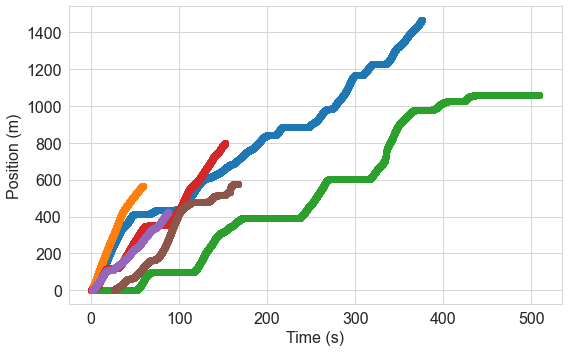

In [7]:

fig, ax = plt.subplots(1,1, figsize=(8,5))

list_id = []
for i in tqdm(comp_df.id.unique()):        
    
    temp = comp_df[comp_df.id==i]
    list_id.append(i)
    if len(temp)>0:
        color = colors[temp.index[0]:temp.index[-1]+1,:]
        color = np.clip(color,0,1)
    
        size = [1 if a>10 or a<-10 else 0.0001 for a in list(temp.a_x)]
        ax.scatter(temp.frame, 0.04*temp['v'].cumsum()/3.6, 
#                       s=size, 
#                       c=color, 
                      alpha=1, 
                      edgecolor='face')
        ax.set_ylabel("Position (m)")
#         ax.set_xticks([])
        ax.set_xlabel("Time (s)")
plt.tight_layout()
plt.show()